## YOLOv4 EigenCAM Application

In [1]:
# DEFINITIONS
modelPath = '../yolo/models/yolov4-csp-schreder.cfg'
testImagePath = '/media/magalhaes/schreder/d3/images/d3_8272_18525.jpg'
weightsPath = '/media/magalhaes/vision/finetune_1669334702/weights/best_ap.pt'

## Some definitions

In [2]:
def select_device(device='', batch_size=None):
    # device = 'cpu' or '0' or '0,1,2,3'
    cpu_request = device.lower() == 'cpu'
    if device and not cpu_request:  # if device requested other than 'cpu'
        os.environ['CUDA_VISIBLE_DEVICES'] = device  # set environment variable
        assert torch.cuda.is_available(), 'CUDA unavailable, invalid device %s requested' % device  # check availablity

    cuda = False if cpu_request else torch.cuda.is_available()
    if cuda:
        c = 1024 ** 2  # bytes to MB
        ng = torch.cuda.device_count()
        if ng > 1 and batch_size:  # check that batch_size is compatible with device_count
            assert batch_size % ng == 0, 'batch-size %g not multiple of GPU count %g' % (batch_size, ng)
        x = [torch.cuda.get_device_properties(i) for i in range(ng)]
        s = f'Using torch {torch.__version__} '
        for i in range(0, ng):
            if i == 1:
                s = ' ' * len(s)
            print("%sCUDA:%g (%s, %dMB)" % (s, i, x[i].name, x[i].total_memory / c))
    else:
        print(f'Using torch {torch.__version__} CPU')

    print('')  # skip a line
    return torch.device('cuda:0' if cuda else 'cpu')

In [3]:
from yolo.models.models import Darknet

/home/guests2/jpn/.conda/envs/magalhaes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
device = select_device('', 16)

Using torch 1.10.1 CUDA:0 (Tesla V100S-PCIE-32GB, 32510MB)



In [8]:
%load_ext autoreload
%autoreload 2

In [6]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import requests
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image

COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


#image_url = "https://upload.wikimedia.org/wikipedia/commons/f/f1/Puppies_%284984818141%29.jpg"
img = np.array(Image.open(r'/media/magalhaes/schreder/d3/images/d3_8272_18525.jpg'))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

#model = torch.load('/content/yolov4-csp-schreder.cfg')
###
# from tool import darknet2pytorch 
# import torch
# model = darknet2pytorch.Darknet('yolov4-csp-schreder.cfg', inference=True)
# model.load_state_dict(torch.load('best_ap.pt'), strict=False)
###
# model_1 = Darknet('yolov4-csp-schreder.cfg').to(device)

###
# import torchvision.transforms as T
# img = Image.open('d3_8272_18525.jpg')
# trans = T.Compose([T.Resize([640, 640]),
#                    T.ToTensor()
#                    ])
# img_trans = trans(img)
# img_trans = img_trans.unsqueeze(0).cpu()

# Load Model

Try 1

In [9]:
model = Darknet(modelPath).to(device)  # create
ckpt = torch.load(weightsPath, map_location=device)  # load checkpoint
state_dict = {k: v for k, v in ckpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
model.load_state_dict(state_dict, strict=False)


<All keys matched successfully>

Try 2

In [ ]:
from tool import darknet2pytorch 
import torch

# load weights from darknet format
#model = darknet2pytorch.Darknet('yolov4-csp-schreder.cfg', inference=True)
#model.load_weights('path/to/weights/yolov4-416.weights')

# save weights to pytorch format
#torch.save(model.state_dict(), 'path/to/save/yolov4-pytorch.pth')

# reload weights from pytorch format
model_pt = darknet2pytorch.Darknet('yolov4-csp-schreder.cfg', inference=True)
model_pt.load_state_dict(torch.load('best_ap.pt'), strict=False)

# Continue

In [17]:
results=model(tensor.cuda())

In [19]:
print(model)

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (Conv2d): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): Mish()
    )
    (1): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): Mish()
    )
    (2): Sequential(
      (Conv2d): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(32, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (activation): Mish()
    )
    (3): Sequential(
      (Conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (BatchNorm2d): BatchNorm2d(64, eps=0.0001, momentum=0.03, affine=True, track_running_stats=True)
      (a

In [16]:
model.eval()
model.cpu()

model(tensor)[0].shape


#boxes, colors, names = parse_detections(results)
#detections = draw_detections(boxes, colors, names, rgb_img.copy())
#Image.fromarray(detections)

torch.Size([1, 25200, 13])

In [34]:
model.module_list[-2]

Sequential(
  (Conv2d): Conv2d(1024, 39, kernel_size=(1, 1), stride=(1, 1))
)

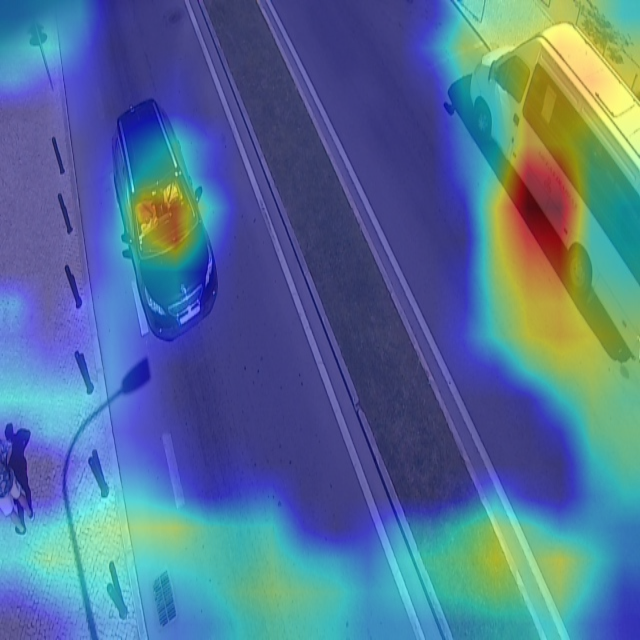

In [17]:
target_layers = [model.module_list[-2]]
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

## YOLO V5

In [6]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()
target_layers = [model.model.model.model[-2]]

results = model([rgb_img])

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /home/guests2/jpn/.cache/torch/hub/master.zip
YOLOv5 🚀 2023-1-17 Python-3.9.15 torch-1.10.1 CUDA:0 (Tesla V100S-PCIE-32GB, 32511MiB)

100%|██████████| 14.1M/14.1M [00:02<00:00, 6.92MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [7]:
print(results)

image 1/1: 640x640 1 car, 1 bus
Speed: 157.3ms pre-process, 1219.7ms inference, 161.8ms NMS per image at shape (1, 3, 640, 640)


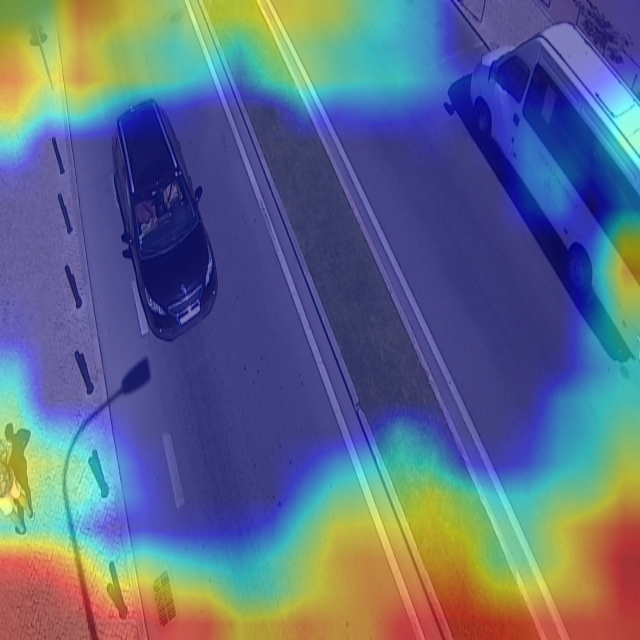

In [8]:
cam = EigenCAM(model, target_layers, use_cuda=False)
grayscale_cam = cam(tensor)[0, :, :]
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)